Step 1 ~ Step 5까지 과정을 이용하여 데이터를 정리하고 훈련 데이터와 검증 데이터를 분리한다. 훈련 데이터는 474개이고, 검증 데이터는 204개가 된다.(7:3)

In [1]:
# 기본 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

'''
[Step 1] 데이터 준비 - Seaborn에서 제공하는 titanic 데이터셋 가져오기
'''

# load_dataset 함수를 사용하여 데이터프레임으로 변환
df = sns.load_dataset('titanic')

'''
[Step 2 ~ 3] 데이터 전처리
'''

# 중복 데이터 제거
df = df.drop_duplicates()

# NaN값이 많은 deck 열을 삭제, embarked와 내용이 겹치는 embark_town 열을 삭제
rdf = df.drop(['deck', 'embark_town'], axis=1)

# age 열에 나이 데이터가 없는 모든 행을 삭제 - NaN 값
rdf = rdf.dropna(subset=['age'], how='any', axis=0)

# embarked 열의 NaN값을 승선도시 중에서 가장 많이 출현한 값으로 치환하기
most_freq = rdf['embarked'].mode()[0]
rdf['embarked'] = rdf['embarked'].fillna(most_freq)

'''
[Step 4] 변수 선택
'''

# 분석에 활용할 열(속성)을 선택 
ndf = rdf[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked']]

# 원핫인코딩 - 범주형 데이터를 모형이 인식할 수 있도록 숫자형으로 변환
onehot_sex = pd.get_dummies(ndf['sex'])
ndf = pd.concat([ndf, onehot_sex], axis=1)

onehot_embarked = pd.get_dummies(ndf['embarked'], prefix='town')
ndf = pd.concat([ndf, onehot_embarked], axis=1)

ndf = ndf.drop(['sex', 'embarked'], axis=1)

'''
[Step 5] 데이터셋 구분 - 훈련용(train data)/ 검증용(test data)
'''

# 속성(변수) 선택
X = ndf[['pclass', 'age', 'sibsp', 'parch', 'female', 'male',
         'town_C', 'town_Q', 'town_S']]  #독립 변수 X
y = ndf['survived']  #종속 변수 Y

# 설명 변수 데이터를 정규화(normalization)
from sklearn import preprocessing

X = preprocessing.StandardScaler().fit(X).transform(X)

# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

print('train data 개수: ', X_train.shape)
print('test data 개수: ', X_test.shape)

train data 개수:  (474, 9)
test data 개수:  (204, 9)


# Step 6 - 모델 학습 및 검증

`sklearn`의 `svm` 모듈의 `SVC()` 함수를 사용하여 SVM 모델 객체(`svm_model`)를 생성한다. 이 때 데이터를 벡터 공간으로 매핑하는 함수를 커널(`kernel`)이라고 하는데, `kernel='rbf'` 옵션을 통해 RBF(Radial Basis Function) 함수를 적용한다. RBF외에도 Linear, Polynimial, Sigmoid 등의 커널이 있다.

훈련 데이터(`X_train`, `y_train`)를 `fit()` 메서드에 전달하여 모델을 학습시킨다. 학습이 끝나면 검증 데이터(`X_test`)를 `predict()` 메서드에 전달하여 예측한 결과를 변수 `y_hat`에 저장한다.

모델의 예측값(`y_hat`)과 실제 데이터(`y_test`)를 비교해보면, 첫 10개의 데이터 중에서 8개가 일치한다.

In [3]:
'''
[Step 6] SVM 분류 모형 - sklearn 사용
'''

# sklearn 라이브러리에서 SVM 분류 모형 가져오기
from sklearn import svm

# 모형 객체 생성 (kernel='rbf' 적용)
svm_model = svm.SVC(kernel='rbf')

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test.values[0:10])

[1 1 0 1 0 0 0 1 1 1]
[1 1 0 1 0 1 1 1 1 0]


모델의 예측능력을 평가하는 지표를 계산한다. 먼저 `confusion_matrix()` 함수를 사용하여 혼동 행렬을 계산한다. 검증 데이터에 속한 204명의 승객 중에서 미생존자(`Negative`)를 정확히 예측한 `TN`은 104명, 미생존자(`Negative`)를 생존자(`Positive`)로 잘못 분류한 `FP`는 19명, 생존자(`Positive`)를 미생존자(`Negative`)로 잘못 예측한 `FN`은 24명, 생존자(`Positive`)를 정확히 예측한 `TP`는 57명이다.

In [4]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics

svm_matrix = metrics.confusion_matrix(y_test, y_hat)
print(svm_matrix)

[[104  19]
 [ 24  57]]


`heatmap()` 함수를 사용하여 혼동 행렬을 히트맵으로 시각화 한다.

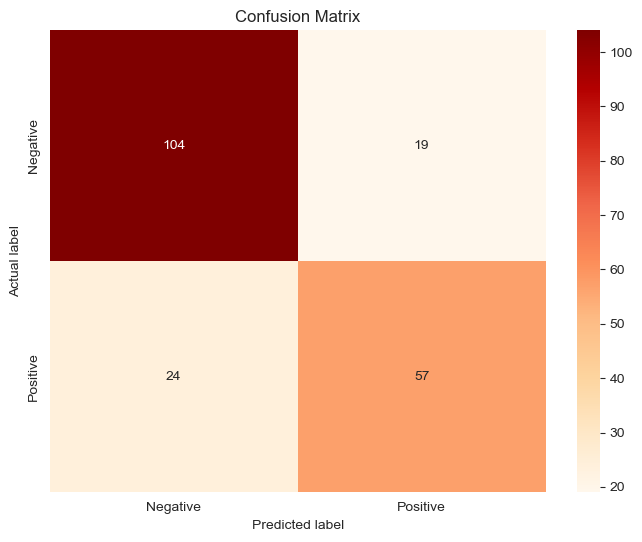

In [5]:
# Confusion Matrix 시각화

plt.figure(figsize=(8, 6))
sns.heatmap(svm_matrix, annot=True, fmt='d', cmap='OrRd',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

분류 평가지표를 요약해주는 classification_report() 함수를 사용한다. 클래스별 성능 지표 중에서 `f1-score`을 보면, 미생존자(0 : `Negative`) 예측의 경우 0.83, 생존자(1 : `Positive`) 예측의 경우 0.73이다. 전체 모델 성능을 보면 정확도(`accuracy`)가 0.79이다. 

KNN에서와 같이 생존자(1 : `Positive`) 클래스에 대한 성능이 상대적을 낮은 편이다. 하지만 `f1-score` 지표를 포함하여 전반적으로 KNN 모델보다 성능이 개선된 것으로 판단된다.

In [6]:
# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)
print(svm_report)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       123
           1       0.75      0.70      0.73        81

    accuracy                           0.79       204
   macro avg       0.78      0.77      0.78       204
weighted avg       0.79      0.79      0.79       204

